In [ ]:
import os
import cv2
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Conv2D, InputLayer
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
def load_dataset_as_patches(hr_root, lr_root, patch_size=33, stride=14, interpolation=cv2.INTER_CUBIC):
    """
    Loads HR and LR images from separate folders, upscales LR images, and generates patch pairs.

    Parameters:
        hr_root (str): Root path to HR images (e.g., data/images/HR).
        lr_root (str): Root path to LR images (e.g., data/images/LR).
        patch_size (int): Size of output patch (default 33x33).
        stride (int): Step size between patches.
        interpolation: OpenCV interpolation method for upscaling LR images.

    Returns:
        X (np.ndarray): Low-resolution image patches (model input).
        Y (np.ndarray): High-resolution image patches (target).
    """
    
    def add_padding(image, patch_size, stride):
        """Add padding to ensure full coverage."""
        
        h, w, c = image.shape
        
        # Calcular cuánto padding se necesita
        pad_h = (patch_size - (h % stride)) % stride if h % stride != 0 else 0
        pad_w = (patch_size - (w % stride)) % stride if w % stride != 0 else 0
        
        # Agregar padding extra para asegurar cobertura completa
        pad_h = max(pad_h, patch_size - stride)
        pad_w = max(pad_w, patch_size - stride)
        
        # Padding reflejado (mirror) para mantener continuidad
        padded_img = np.pad(
            image, 
            ((0, pad_h), (0, pad_w), (0, 0)), 
            mode='reflect'
        )
        
        return padded_img
    
    if not os.path.exists(hr_root) or not os.path.exists(lr_root):
        raise ValueError("Both HR and LR root directories must exist.")
    if not os.path.isdir(hr_root) or not os.path.isdir(lr_root):
        raise ValueError("Both HR and LR root paths must be directories.")
    if not isinstance(patch_size, int) or patch_size <= 0:
        raise ValueError("Patch size must be a positive integer.")
    if not isinstance(stride, int) or stride <= 0:
        raise ValueError("Stride must be a positive integer.")
    
    X, Y = [], []
    
    def get_all_image_paths(root):
        image_paths = []
        
        for dirpath, _, filenames in os.walk(root):
            for filename in filenames:
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(os.path.join(dirpath, filename))
        
        return sorted(image_paths)

    hr_paths = get_all_image_paths(hr_root)
    lr_paths = get_all_image_paths(lr_root)
    
    if not hr_paths or not lr_paths:
        raise ValueError("No images found in the specified directories.")

    # Match HR and LR images by filename (after last folder)
    hr_dict = {os.path.basename(p): p for p in hr_paths}
    lr_dict = {os.path.basename(p): p for p in lr_paths}
    common_filenames = sorted(set(hr_dict.keys()) & set(lr_dict.keys()))
    
    non_common_images = set()

    for fname in common_filenames:
        hr_img = cv2.imread(hr_dict[fname], cv2.IMREAD_COLOR)
        lr_img = cv2.imread(lr_dict[fname], cv2.IMREAD_COLOR)
        
        if hr_img is None or lr_img is None:
            non_common_images.add(fname)
            continue

        # Normalize
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Upscale LR to HR size
        h, w, _ = hr_img.shape
        lr_up = cv2.resize(lr_img, (w, h), interpolation=interpolation)
        
        # Add padding to ensure full coverage
        hr_img = add_padding(hr_img, patch_size, stride)
        lr_up = add_padding(lr_up, patch_size, stride)

        # Generate patches
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                hr_patch = hr_img[i:i+patch_size, j:j+patch_size, :]
                lr_patch = lr_up[i:i+patch_size, j:j+patch_size, :]
                
                X.append(lr_patch)
                Y.append(hr_patch)
    
    if non_common_images:
        print(f"Skipped {len(non_common_images)} images due to missing files: {', '.join(non_common_images)}")

    return np.array(X), np.array(Y), h, w

In [29]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# create a function for ssimilarity index (SSIM)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

class SRCNNModel:
    def __init__(self):
        self.model = None
        self._trained = False

    def setup_model(self, input_shape=(33, 33, 3), learning_rate=1e-4, loss="mean_squared_error", from_pretrained=False, pretrained_path=None):
        """Sets up the model: either loads pretrained or builds + compiles a new model."""
        
        if from_pretrained:
            if pretrained_path is None or not os.path.isfile(pretrained_path):
                raise FileNotFoundError(f"Pretrained model file not found at {pretrained_path}")
            
            self.model = load_model(pretrained_path, custom_objects={"psnr": psnr, "ssim": ssim})
            print(f"Loaded pretrained model from {pretrained_path}")
            self._trained = True
        else:
            self._build_model(input_shape)
            self._compile_model(learning_rate, loss)

    def _build_model(self, input_shape):
        """Builds the SRCNN model using Sequential API."""
        
        self.model = Sequential([
            InputLayer(input_shape=input_shape), 
            Conv2D(64, (9, 9), activation="relu", padding="same"),
            Conv2D(32, (1, 1), activation="relu", padding="same"),
            Conv2D(3, (5, 5), activation="linear", padding="same")
        ])

    def _compile_model(self, learning_rate, loss):
        """Compiles the model."""
        
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[psnr, ssim])
        self.model.summary()

    def fit(self, X_train, Y_train, X_val, Y_val, batch_size=16, epochs=50, use_augmentation=False):
        """Trains the model with optional data augmentation and callbacks."""
        
        if self.model is None:
            raise ValueError("Model has not been set up.")
        
        devices = tf.config.list_physical_devices("GPU")
        if devices:
            print("Training on GPU:", devices[0].name)
        else:
            print("Training on CPU")

        # Callbacks
        callbacks = [
            EarlyStopping(monitor="loss", patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor="loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
        ]

        if use_augmentation:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True
            )
            
            train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)
            val_gen = datagen.flow(X_val, Y_val, batch_size=batch_size)
        
            self.model.fit(
                train_gen,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=epochs,
                validation_data=val_gen,
                validation_steps=len(X_val) // batch_size,
                callbacks=callbacks
            )
        else:
            self.model.fit(
                X_train, Y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, Y_val),
                callbacks=callbacks
            )

        self._trained = True

    def evaluate(self, X_test, Y_test):
        """Evaluates the model."""
        
        if not self._trained:
            raise RuntimeError("Model has not been trained.")
        
        results = self.model.evaluate(X_test, Y_test)
        print(f"Loss: {results[0]:.4f}, PSNR: {results[1]:.2f} dB, SSIM: {results[2]:.4f}")
        
        return results
    
    def super_resolve_image(self, image_path, hr_h, hr_w, patch_size=33, stride=14, interpolation=cv2.INTER_CUBIC):
        """Performs super-resolution using padding to avoid border issues."""
        
        if not self._trained:
            raise RuntimeError("Model has not been trained.")
        if not os.path.isfile(image_path):
            raise FileNotFoundError(f"Image file not found at {image_path}")
        
        def add_padding(image, patch_size, stride):
            """Add padding to ensure full coverage."""
            
            h, w, c = image.shape
            
            # Calcular cuánto padding se necesita
            pad_h = (patch_size - (h % stride)) % stride if h % stride != 0 else 0
            pad_w = (patch_size - (w % stride)) % stride if w % stride != 0 else 0
            
            # Agregar padding extra para asegurar cobertura completa
            pad_h = max(pad_h, patch_size - stride)
            pad_w = max(pad_w, patch_size - stride)
            
            # Padding reflejado (mirror) para mantener continuidad
            padded_img = np.pad(
                image, 
                ((0, pad_h), (0, pad_w), (0, 0)), 
                mode='reflect'
            )
            
            return padded_img, (h, w)
        
        def extract_patches_from_image(image, patch_size=33, stride=14):
            """Extracts patches from an image."""
            
            h, w, _ = image.shape
            patches = []
            positions = []

            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    patch = image[i:i+patch_size, j:j+patch_size, :]
                    patches.append(patch)
                    positions.append((i, j))

            return np.array(patches), positions

        def reconstruct_from_patches(patches, positions, padded_shape, original_shape, patch_size=33):
            """Reconstructs image and crops to original size."""
            
            h_pad, w_pad = padded_shape[:2]
            h_orig, w_orig = original_shape
            
            reconstructed = np.zeros((h_pad, w_pad, 3), dtype=np.float32)
            weight = np.zeros((h_pad, w_pad, 3), dtype=np.float32)

            for patch, (i, j) in zip(patches, positions):
                reconstructed[i:i+patch_size, j:j+patch_size, :] += patch
                weight[i:i+patch_size, j:j+patch_size, :] += 1.0

            # Evitar división por cero
            reconstructed = np.divide(
                reconstructed, 
                weight, 
                out=np.zeros_like(reconstructed), 
                where=weight!=0
            )
            
            # Recortar al tamaño original
            reconstructed = reconstructed[:h_orig, :w_orig, :]
            
            return np.clip(reconstructed, 0, 1)

        # Load and normalize original image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        
        img_lr_up = cv2.resize(img, (hr_w, hr_h), interpolation=interpolation)
        
        # Agregar padding
        padded_img, original_shape = add_padding(img_lr_up, patch_size, stride)
        
        print(f"Original shape: {img_lr_up.shape}")
        print(f"Padded shape: {padded_img.shape}")

        # Extraer patches
        patches, positions = extract_patches_from_image(padded_img, patch_size, stride)
        patches = np.array(patches)
        
        print(f"Total patches: {len(patches)}")

        # Predict
        preds = self.model.predict(patches, batch_size=16)

        # Reconstruct y recortar
        sr_img = reconstruct_from_patches(preds, positions, padded_img.shape, original_shape, patch_size)

        return sr_img

    def save(self, directory="models/SRCNN"):
        """Saves the model to a .h5 file with a timestamp."""
        
        if not self._trained:
            raise RuntimeError("Cannot save an untrained model.")
        
        os.makedirs(directory, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = os.path.join(directory, f"SRCNN_{timestamp}.h5")
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

In [19]:
PATCH_SIZE = 33
STRIDE = 14
INTERPOLATION = cv2.INTER_CUBIC
RANDOM_SEED = 42

In [ ]:
# X -> Low-resolution patches (model input) (Low-resolution images with same size as Y but noised)
# Y -> High-resolution patches (target)
X, Y, hr_h, hr_w = load_dataset_as_patches("../../data/images/HR", "../../data/images/LR", patch_size=PATCH_SIZE, stride=STRIDE, interpolation=INTERPOLATION)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

In [21]:
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X shape: (152576, 33, 33, 3), Y shape: (152576, 33, 33, 3)
X_train shape: (109854, 33, 33, 3), Y_train shape: (109854, 33, 33, 3)
X_val shape: (12206, 33, 33, 3), Y_val shape: (12206, 33, 33, 3)
X_test shape: (30516, 33, 33, 3), Y_test shape: (30516, 33, 33, 3)


In [22]:
# calculate psnr between X and Y first patches
psnr_value = psnr(Y[0:1], X[0:1])
print(f"PSNR between first patches: {psnr_value.numpy()[0]:.2f} dB")

PSNR between first patches: 35.16 dB


In [23]:
model = SRCNNModel()

model.setup_model(input_shape=X_train.shape[1:], learning_rate=1e-4, loss="mean_squared_error", from_pretrained=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        15616     
                                                                 
 conv2d_4 (Conv2D)           (None, 33, 33, 32)        2080      
                                                                 
 conv2d_5 (Conv2D)           (None, 33, 33, 3)         2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, Y_train, X_val, Y_val, batch_size=16, epochs=50, use_augmentation=True)

Training on GPU: /physical_device:GPU:0
Epoch 1/50
6865/6865 [==============================] - 54s 8ms/step - loss: 0.0070 - psnr: 24.0939 - ssim: 0.5422 - val_loss: 0.0053 - val_psnr: 24.5799 - val_ssim: 0.5467 - lr: 1.0000e-04
Epoch 2/50
6865/6865 [==============================] - 56s 8ms/step - loss: 0.0054 - psnr: 24.6098 - ssim: 0.5487 - val_loss: 0.0053 - val_psnr: 24.6822 - val_ssim: 0.5483 - lr: 1.0000e-04
Epoch 3/50
6865/6865 [==============================] - 55s 8ms/step - loss: 0.0053 - psnr: 24.6509 - ssim: 0.5492 - val_loss: 0.0053 - val_psnr: 24.6899 - val_ssim: 0.5476 - lr: 1.0000e-04
Epoch 4/50
6862/6865 [============================>.] - ETA: 0s - loss: 0.0053 - psnr: 24.6867 - ssim: 0.5501
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6865/6865 [==============================] - 57s 8ms/step - loss: 0.0053 - psnr: 24.6867 - ssim: 0.5501 - val_loss: 0.0053 - val_psnr: 24.6375 - val_ssim: 0.5470 - lr: 1.0000e-04
Epoch 5/50
6865/6865 [===

In [25]:
model.evaluate(X_test, Y_test)

954/954 [==============================] - 4s 4ms/step - loss: 0.0030 - psnr: 27.0695 - ssim: 0.6383
Loss: 0.0030, PSNR: 27.07 dB


[0.002972400514408946, 27.069454193115234, 0.6383132934570312]

In [26]:
model.save()

Model saved to models/SRCNN\SRCNN_20250624_221949.h5


In [27]:
pretrained_model = SRCNNModel()

pretrained_model.setup_model(from_pretrained=True, pretrained_path="models/SRCNN\SRCNN_20250624_221949.h5")

Loaded pretrained model from models/SRCNN\SRCNN_20250624_221949.h5


Original shape: (478, 478, 3)
Padded shape: (497, 497, 3)
Total patches: 1156
73/73 [==============================] - 0s 4ms/step


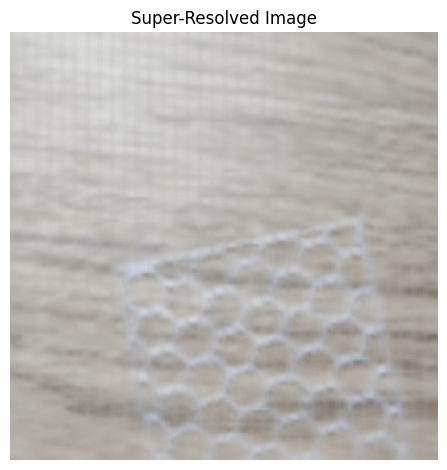

In [28]:
sr_image = pretrained_model.super_resolve_image("low_z_offset.png", hr_h, hr_w, patch_size=PATCH_SIZE, stride=STRIDE, interpolation=INTERPOLATION)
sr_image_uint8 = (sr_image * 255).astype(np.uint8)

plt.imshow(sr_image_uint8)
plt.axis('off')
plt.title("Super-Resolved Image")
plt.tight_layout()
plt.show()

This is a common and important observation in super-resolution training. Here’s why your **initial PSNR between X and Y is very high (~41 dB)**, but your **model only reaches ~25 dB**:

---

### **Why is the initial PSNR so high?**

- **X and Y are almost identical at the start:**  
  When you compute `psnr(Y[0:1], X[0:1])` before training, you are comparing the HR patch (`Y`) to the upscaled LR patch (`X`).  
  If your LR images are generated by simple bicubic downsampling and then upsampling, the upscaled LR is already very close to the HR image—hence the high PSNR.

---

### **Why does the model only reach ~25 dB?**

- **Model Output ≠ Bicubic Upsample:**  
  The model is learning to map the upscaled LR patch to the HR patch.  
  However, the model’s output is not exactly the same as the bicubic upsample (which is what your X is), and it may introduce small errors or artifacts, especially if the model is not powerful enough or the loss function is not optimal.
- **PSNR is measured between model output and HR:**  
  The model’s output is compared to the HR image, and unless the model learns to perfectly replicate the bicubic upsample (which is hard for a small CNN), the PSNR will be lower.
- **Bicubic upsampling is a strong baseline:**  
  If your LR images are generated by bicubic downsampling and then upsampling, the bicubic upsample itself is very close to the HR image.  
  Your model is being asked to do better than (or at least match) bicubic, which is difficult for a simple SRCNN.
- **Model capacity and training:**  
  SRCNN is a shallow network. It may not have enough capacity to perfectly learn the mapping, especially if your dataset is complex or noisy.

---

### **Summary Table**

| Comparison                | Typical PSNR | Why?                                      |
|---------------------------|--------------|--------------------------------------------|
| HR vs. Bicubic Upsample   | 35–45 dB     | Bicubic upsample is very close to HR       |
| Model Output vs. HR       | 23–28 dB     | Model output is not as close as bicubic    |

---

### **What does this mean?**

- **Your model is not underperforming:**  
  It is typical for SRCNN to reach 24–27 dB on real data.  
  Bicubic upsampling is a very strong baseline, and your model is not able to perfectly replicate it.
- **If you want higher PSNR:**  
  - Use a deeper/better model (EDSR, VDSR, etc.)
  - Use more realistic LR degradations (not just bicubic)
  - Try perceptual or adversarial losses for better perceptual quality (though PSNR may not increase much)

---

**In short:**  
The initial PSNR is high because bicubic upsampling is already very close to the HR image. The model’s output is not as close, so the PSNR drops to a more realistic value for learned super-resolution.

If you want to match or beat bicubic, you need a more powerful model and/or more sophisticated training.